In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
df = pd.read_csv('reddit_exercise_data.csv')

# Exploration

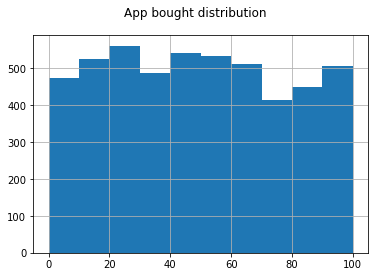

In [3]:
df['app_bought'].hist()
plt.suptitle('App bought distribution')
plt.show()

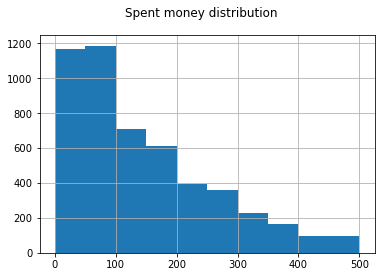

In [4]:
df['money_spent'].hist()
plt.suptitle('Spent money distribution')
plt.show()

## Data cleaning

In [5]:
def parse_date(date):    
    date_format = ['%y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M:%S', '%m/%d/%y']
    for f in date_format:
        try:
            parsed_date = datetime.strptime(date, f) 
            break 
        except ValueError:
            pass
    return parsed_date

In [6]:
def bucket_data(data):
    return pd.cut(data, 5)

In [7]:
def clean_data(df):
    df['date'] = pd.to_datetime(df['date'].apply(parse_date))
    df['app_bought_bucket'] = bucket_data(df['app_bought'])
    df['money_spent_bucket'] = bucket_data(df['money_spent'])
    df['review'] = df['review'].str.replace("'", " ")
    df['title'] = df['title'].str.replace("'", " ")
    return df

In [8]:
df = clean_data(df)

In [9]:
df.to_csv('cleaned_data.csv')

## SQlite

In [10]:
import sqlite3

class ReviewTable():
    INSERT_STATEMENT = """ INSERT INTO reviews VALUES('{}', '{}', '{}', {}, '{}', {}, {}, '{}', '{}' ) """
    
    def __init__(self, db='exercise_database.db'):
        self.conn = sqlite3.connect(db)
        self.cursor = self.conn.cursor()
    
    def insert(self, values):
        try:
            q = ReviewTable.INSERT_STATEMENT.format(values['title'], 
                                    values['review'],
                                    values['iso'], 
                                    values['score'],
                                    values['date'], 
                                    values['app_bought'], 
                                    values['money_spent'],
                                    values['app_bought_bucket'],
                                    values['money_spent_bucket']
                                   )
            self.cursor.execute(q)
            self.conn.commit()
        except KeyError:
            print('missing data')
        except sqlite3.Error as e:
            print('something went wrong' + e)
            
    def clear_table(self):
        self.cursor.execute('DELETE FROM reviews')
        self.conn.commit()
    
    def count_all(self):
        self.cursor.execute('SELECT count(*) FROM reviews')
        self.conn.commit()
        return  self.cursor.fetchall()
    
    def query(self, query):
        self.cursor.execute(query)
        self.conn.commit()
        return  self.cursor.fetchall()

In [11]:
review_table = ReviewTable(db='exercise_database.db')

In [12]:
review_table.clear_table()

In [13]:
for index, row in df.iterrows():
    review_table.insert(row)

In [13]:
review_table.count_all()

[(5000,)]

### 1. Average score by ISO

In [14]:
pd.read_sql_query('SELECT avg(score), iso FROM reviews GROUP BY 2', review_table.conn)\
        .head(5)\
        .sort_values('avg(score)', ascending=True)

,avg(score),iso
3,4.461538,AT
4,4.505618,AU
0,4.714286,AE
2,4.900000,AR
1,5.000000,AL


### 2. Maximum score by app_bought_bucket

In [15]:
pd.read_sql_query('SELECT max(score), apps_bought_bucket FROM reviews GROUP BY 2', review_table.conn)\
        .sort_values('max(score)', ascending=True)

,max(score),apps_bought_bucket
0,5,"(-0.1, 20.0]"
1,5,"(20.0, 40.0]"
2,5,"(40.0, 60.0]"
3,5,"(60.0, 80.0]"
4,5,"(80.0, 100.0]"


### 3. Average score over time (day)

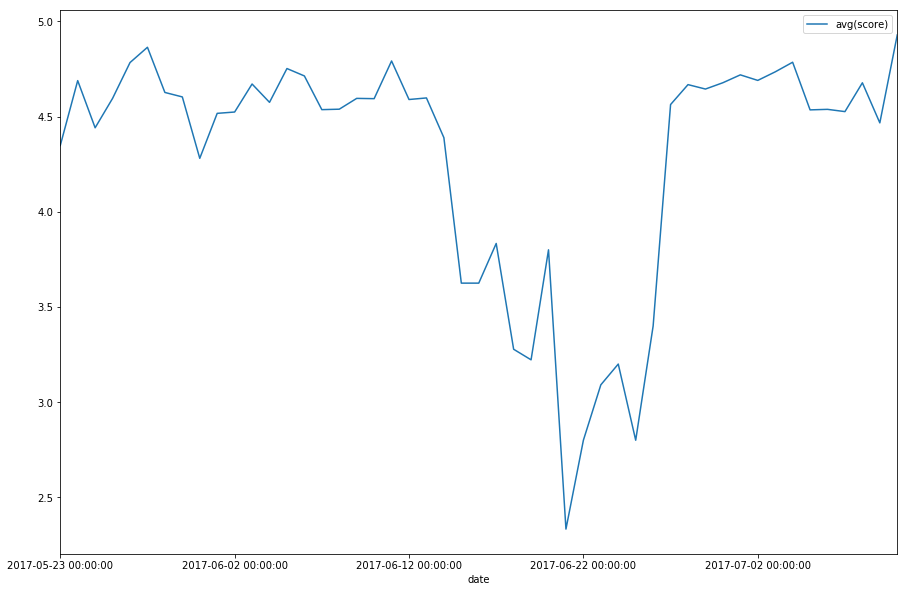

In [16]:
avg_score_over_time = pd.read_sql_query('SELECT date, avg(score) FROM reviews GROUP BY 1', review_table.conn).set_index('date')
avg_score_over_time.plot(figsize=(15, 10))
plt.show()